In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import keras
import random

from utils import data_preprocess, plot_confusion_matrix, DataGenerator, get_n_zeros
from model import build_model

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Data preparation

In [2]:
data_dir = "/data/put_data/cmchang/gynecology/data/"
d = pd.read_csv(os.path.join(data_dir, 'data_merged.csv'))

# ['variability', 'deceleration', 'management', 'UA']

FLAG_target = 'variability'
n_classes = len(set(d[FLAG_target]))

In [3]:
d.head()

,ID,bed,date,start,end,FHB,variability,UA,UA_duration,UA_interval,...,b-590,b-591,b-592,b-593,b-594,b-595,b-596,b-597,b-598,b-599
0,288427,LDR1,2013-01-15,17:20,17:30,140,0,0,0.0,NaN,...,140,140,140,0,142,147,149,152,154,148
1,288427,LDR1,2013-01-15,17:54,18:04,140,0,1,60.0,120.0,...,0,147,150,157,157,0,151,150,150,148
2,288427,LDR1,2013-01-15,18:15,18:25,155,0,0,0.0,NaN,...,142,146,149,0,150,146,141,140,0,140
3,288427,LDR1,2013-01-15,18:29,18:39,150,0,0,0.0,NaN,...,150,150,151,154,154,154,154,155,156,157
4,288427,LDR1,2013-01-15,18:39,18:49,155,0,1,120.0,60.0,...,160,0,160,158,157,154,0,154,153,152


In [4]:
acceptable_zeros_threshold = 90
d = d[get_n_zeros(np.array(d[[k for k in d.columns if 'b-' in k]], dtype=np.float)) <= acceptable_zeros_threshold]

In [5]:
for k in d.columns:
    if 'b-' in k or 'm-' in k:
        print(k, end='\r')
        d.loc[d[k]==0, k] = np.nan

In [6]:
from sklearn.model_selection import train_test_split
train_id, valid_id = train_test_split(list(set(d.ID)), test_size=0.3, random_state=13)

train_d, valid_d = d[[k in set(train_id) for k in d.ID]], d[[k in set(valid_id) for k in d.ID]]

In [7]:
# train_db = np.array(train_d[[k for k in train_d.columns if 'b-' in k]], dtype=np.float)
# train_dm = np.array(train_d[[k for k in train_d.columns if 'm-' in k]], dtype=np.float)

# valid_db = np.array(valid_d[[k for k in valid_d.columns if 'b-' in k]], dtype=np.float)
# valid_dm = np.array(valid_d[[k for k in valid_d.columns if 'm-' in k]], dtype=np.float)

In [8]:
train_db = np.array(train_d[[k for k in train_d.columns if 'b-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)
train_dm = np.array(train_d[[k for k in train_d.columns if 'm-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)

valid_db = np.array(valid_d[[k for k in valid_d.columns if 'b-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)
valid_dm = np.array(valid_d[[k for k in valid_d.columns if 'm-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)

In [9]:
Xtrain = np.stack([train_db, train_dm], axis=2)
Xvalid = np.stack([valid_db, valid_dm], axis=2)

In [10]:
Ytrain = keras.utils.to_categorical(np.array(train_d[FLAG_target]), num_classes=n_classes)
Yvalid = keras.utils.to_categorical(np.array(valid_d[FLAG_target]), num_classes=n_classes)

In [11]:
# Convolution
kernel_size = 3
filters = 64
strides = 1
layers = 10
activation='relu'
kernel_initializer = 'he_normal'

# input, output
FLAG_batch_size = 16
FLAG_length = 300
FLAG_n_channel = 2

# Training
lr_rate = 1e-5

In [12]:
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(Ytrain, axis=1)
d_class_weight = compute_class_weight('balanced', np.unique(y_integers), y_integers)
class_weight = dict(enumerate(d_class_weight))
print(class_weight)

{0: 0.5694444444444444, 1: 4.1}


In [13]:
# class_weight = {0: 1.0, 1: #4.0}

In [14]:
# from collections import Counter
# class_weight = dict()
# for k, v in dict(Counter(train_d[FLAG_target])).items():
#     class_weight[k] = min(train_d.shape[0]//v, 25)
# print(class_weight)

In [15]:
# moving across a sequence, we slice out "k_slice" segments with a constant interval
# in order to increase validation data
"""
# ex:  |------------------|
# 1    |------|
# 2       |------|
# 3          |------|
# 4             |------|
# 5                |------|
"""


k_slice = 5
intvl = (Xvalid.shape[1] - FLAG_length)//5

Xtest = np.empty((Xvalid.shape[0]*k_slice, FLAG_length, Xvalid.shape[2]))
Ytest = np.empty((Yvalid.shape[0]*k_slice, Yvalid.shape[1]))
Wtest = np.empty((Yvalid.shape[0]*k_slice,))

for k in range(k_slice):
    st = k * Xvalid.shape[0]
    for i in range(Xvalid.shape[0]):
        # print(st+i)
        Xtest[st+i,:,:] = data_preprocess(Xvalid[i,k*intvl:(k*intvl+FLAG_length),:])
        Ytest[st+i,:] = Yvalid[i,:]
        Wtest[st+i] = class_weight[np.argmax(Yvalid[i,:])]
    
print('train: {0}, valid: {1}'.format(Xtrain.shape, Xtest.shape))

train: (123, 600, 2), valid: (270, 300, 2)


In [16]:
FLAG_model_save = os.path.join('/data/put_data/cmchang/gynecology/model/', FLAG_target+'_filter_interpolate')
if not os.path.exists(FLAG_model_save):
    os.mkdir(FLAG_model_save)
    print('directory {0} is created.'.format(FLAG_model_save))
else:
    print('directory {0} already exists.'.format(FLAG_model_save))

directory /data/put_data/cmchang/gynecology/model/variability_filter_interpolate already exists.


In [17]:
def my_generator(Xtrain, Ytrain, length=300, n_channel=2, n_classes=2, random_noise=True, batch_size=16):
    n_sample = Xtrain.shape[0]
    n_length = Xtrain.shape[1]
    ind = list(range(n_sample))
    x = np.empty((batch_size, length, n_channel), dtype=np.float)
    y = np.empty((batch_size, n_classes), dtype=int)

    while True:
        np.random.shuffle(ind)
        for i in range(n_sample//batch_size):
            st = random.choice(np.arange(0, Xtrain.shape[1] - length))
            i_batch = ind[i*batch_size:(i+1)*batch_size]
            for j, k in enumerate(i_batch):
                x[j,:] = data_preprocess(Xtrain[k,st:(st+length),:], random_noise=random_noise)
                y[j,:] = Ytrain[k,:]
            yield x, y

###  Model

In [18]:
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam, SGD, Adamax

In [19]:
model = build_model(length=FLAG_length, n_channel=FLAG_n_channel, n_classes=n_classes, filters=filters, kernel_size=kernel_size, layers=layers,
                   activation=activation, kernel_initializer=kernel_initializer, l_2=0.0)

In [20]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 300, 2)        0                                            
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 300, 64)       448         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 300, 64)       256         conv1d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 300, 64)       0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [21]:
adam = Adamax(lr=lr_rate, beta_1=0.5, beta_2=0.999, epsilon=1e-08, decay = 0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

#### Declare DataGenerator for Keras

In [22]:
train_gen = DataGenerator(Xtrain, Ytrain, length=FLAG_length, batch_size=32, random_noise=True, shuffle=True)

In [23]:
csv_logger = keras.callbacks.CSVLogger(os.path.join(FLAG_model_save, 'training.log'))
checkpoint = keras.callbacks.ModelCheckpoint(os.path.join(FLAG_model_save, 'model.h5'), 
                                             monitor='val_loss', 
                                             verbose=1, 
                                             save_best_only=True,
                                             save_weights_only=False,
                                             mode='min',
                                             period=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor = 0.5, patience = 5, min_lr = 0, cooldown = 5, verbose = True)

In [24]:
# Train model on dataset
model.fit_generator(generator=my_generator(Xtrain, Ytrain, 
                                           length=FLAG_length, 
                                           n_channel=FLAG_n_channel, 
                                           n_classes=n_classes,
                                           random_noise=False),
                    class_weight=class_weight,
                    validation_data=(Xtest, Ytest, Wtest),
                    steps_per_epoch=50, 
                    epochs=100,
                    callbacks=[csv_logger,
                               reduce_lr, 
                               checkpoint])

Epoch 1/100
50/50 [==============================] - 14s - loss: 0.7994 - acc: 0.5413 - val_loss: 0.7521 - val_acc: 0.3593
Epoch 2/100
50/50 [==============================] - 2s - loss: 0.6960 - acc: 0.5287 - val_loss: 0.7016 - val_acc: 0.2778
Epoch 3/100
50/50 [==============================] - 2s - loss: 0.6416 - acc: 0.5713 - val_loss: 0.6984 - val_acc: 0.2741
Epoch 4/100
50/50 [==============================] - 2s - loss: 0.5799 - acc: 0.6112 - val_loss: 0.7104 - val_acc: 0.2815
Epoch 5/100
50/50 [==============================] - 3s - loss: 0.5782 - acc: 0.5950 - val_loss: 0.7167 - val_acc: 0.3037
Epoch 6/100
50/50 [==============================] - 3s - loss: 0.5808 - acc: 0.6012 - val_loss: 0.7120 - val_acc: 0.3148
Epoch 7/100
50/50 [==============================] - 4s - loss: 0.5285 - acc: 0.6188 - val_loss: 0.7066 - val_acc: 0.3593
Epoch 8/100
50/50 [==============================] - 4s - loss: 0.5253 - acc: 0.6188 - val_loss: 0.6974 - val_acc: 0.3926
Epoch 9/100
50/50 [====

50/50 [==============================] - 2s - loss: 0.4066 - acc: 0.7188 - val_loss: 0.6056 - val_acc: 0.6037
Epoch 28/100
50/50 [==============================] - 3s - loss: 0.4077 - acc: 0.7175 - val_loss: 0.6066 - val_acc: 0.6074
Epoch 29/100
50/50 [==============================] - 2s - loss: 0.3931 - acc: 0.7438 - val_loss: 0.6094 - val_acc: 0.5963
Epoch 30/100
49/50 [============================>.] - ETA: 0s - loss: 0.3973 - acc: 0.7232
Epoch 00029: reducing learning rate to 4.999999873689376e-06.
Epoch 00029: val_loss did not improve
50/50 [==============================] - 3s - loss: 0.3991 - acc: 0.7250 - val_loss: 0.6056 - val_acc: 0.6037
Epoch 31/100
50/50 [==============================] - 3s - loss: 0.3704 - acc: 0.7463 - val_loss: 0.6038 - val_acc: 0.6148
Epoch 32/100
50/50 [==============================] - 3s - loss: 0.3798 - acc: 0.7412 - val_loss: 0.6018 - val_acc: 0.6074
Epoch 33/100
50/50 [==============================] - 3s - loss: 0.3953 - acc: 0.7412 - val_loss:

50/50 [==============================] - 3s - loss: 0.3449 - acc: 0.7812 - val_loss: 0.5446 - val_acc: 0.6963
Epoch 55/100
50/50 [==============================] - 3s - loss: 0.3895 - acc: 0.7675 - val_loss: 0.5434 - val_acc: 0.6926
Epoch 56/100
50/50 [==============================] - 3s - loss: 0.3719 - acc: 0.7575 - val_loss: 0.5434 - val_acc: 0.6889
Epoch 57/100
50/50 [==============================] - 2s - loss: 0.3410 - acc: 0.7800 - val_loss: 0.5439 - val_acc: 0.6926
Epoch 58/100
50/50 [==============================] - 2s - loss: 0.3331 - acc: 0.7687 - val_loss: 0.5409 - val_acc: 0.6889
Epoch 59/100
50/50 [==============================] - 2s - loss: 0.3364 - acc: 0.7900 - val_loss: 0.5386 - val_acc: 0.6963
Epoch 60/100
50/50 [==============================] - 2s - loss: 0.3260 - acc: 0.8100 - val_loss: 0.5395 - val_acc: 0.6926
Epoch 61/100
50/50 [==============================] - 4s - loss: 0.3465 - acc: 0.7800 - val_loss: 0.5355 - val_acc: 0.6963
Epoch 62/100
50/50 [=========

50/50 [==============================] - 4s - loss: 0.3508 - acc: 0.7987 - val_loss: 0.5087 - val_acc: 0.7370
Epoch 82/100
50/50 [==============================] - 3s - loss: 0.3321 - acc: 0.8013 - val_loss: 0.5128 - val_acc: 0.7370
Epoch 83/100
50/50 [==============================] - 3s - loss: 0.3184 - acc: 0.7987 - val_loss: 0.5113 - val_acc: 0.7481
Epoch 84/100
50/50 [==============================] - 3s - loss: 0.3476 - acc: 0.8125 - val_loss: 0.5093 - val_acc: 0.7481
Epoch 85/100
50/50 [==============================] - 4s - loss: 0.3369 - acc: 0.8125 - val_loss: 0.5133 - val_acc: 0.7481
Epoch 86/100
50/50 [==============================] - 4s - loss: 0.3784 - acc: 0.7925 - val_loss: 0.5145 - val_acc: 0.7481
Epoch 87/100
49/50 [============================>.] - ETA: 0s - loss: 0.3395 - acc: 0.8087
Epoch 00086: reducing learning rate to 2.499999936844688e-06.
Epoch 00086: val_loss did not improve
50/50 [==============================] - 4s - loss: 0.3370 - acc: 0.8113 - val_loss:

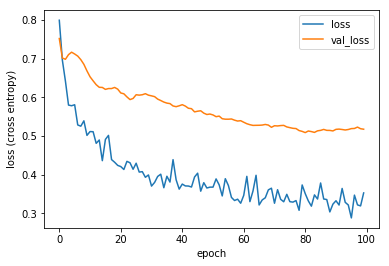

In [25]:
loss = pd.read_table(csv_logger.filename, delimiter=',')

plt.plot(loss.epoch, loss.loss, label='loss')
plt.plot(loss.epoch, loss.val_loss, label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss (cross entropy)')
# plt.xlim([1,50])
# plt.ylim([0,2])
plt.savefig(os.path.join(FLAG_model_save, 'loss.png'))

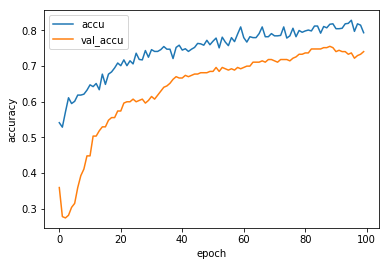

In [26]:
loss = pd.read_table(csv_logger.filename, delimiter=',')

plt.plot(loss.epoch, loss.acc, label='accu')
plt.plot(loss.epoch, loss.val_acc, label='val_accu')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig(os.path.join(FLAG_model_save, 'accu.png'))

In [27]:
from keras.models import load_model
trained_model = load_model(os.path.join(FLAG_model_save,'model.h5'))

In [28]:
Pred = trained_model.predict(Xtest)

In [29]:
ypred_aug = np.argmax(Pred,axis=1)
ytest_aug = np.argmax(Ytest,axis=1)

In [30]:
ypred = (np.mean(ypred_aug.reshape(5,-1), axis=0) > 0.6) + 0 # voting
# ypred = np.argmax(np.mean(ypred_aug.reshape(5, 84, 2), axis=0), axis=1)
ytest = np.argmax(Yvalid, axis=1)

In [31]:
from collections import Counter
Counter(np.mean(ypred_aug.reshape(5,-1), axis=0))

Counter({0.0: 22, 0.2: 7, 0.4: 5, 0.6: 1, 0.8: 8, 1.0: 11})

In [32]:
Counter(np.mean(ypred_aug.reshape(5,-1), axis=0)[ypred != ytest])

Counter({0.8: 6, 1.0: 5})

#### save wrong prediction plots

In [33]:
if not os.path.exists(os.path.join(FLAG_model_save, 'wrong/')):
    os.mkdir(os.path.join(FLAG_model_save, 'wrong/'))
    print('{0} created'.format(os.path.join(FLAG_model_save, 'wrong/')))

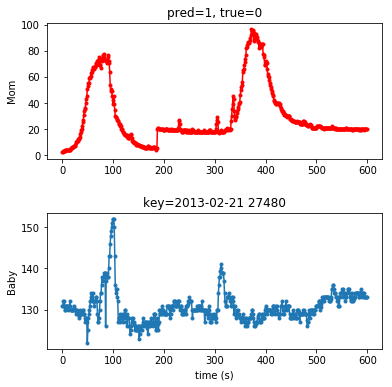

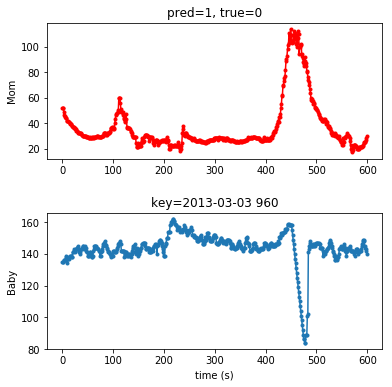

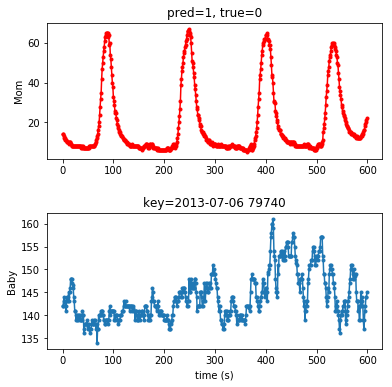

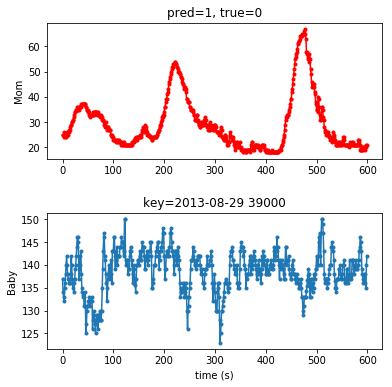

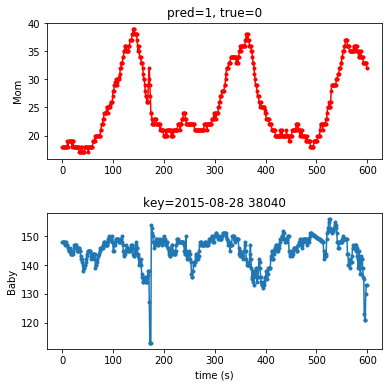

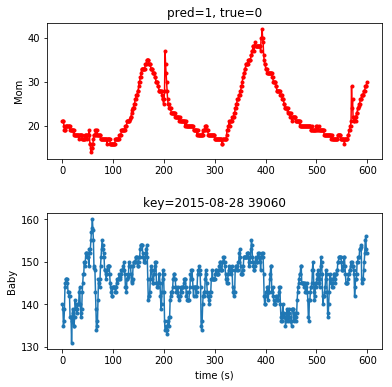

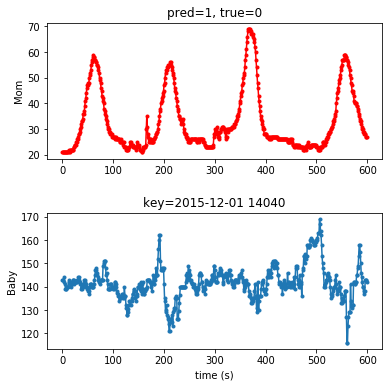

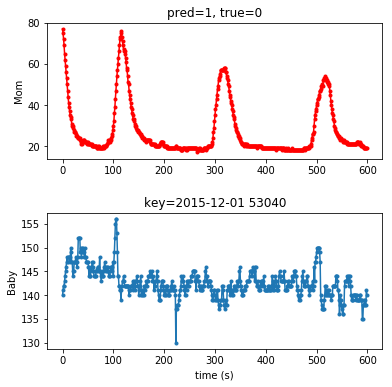

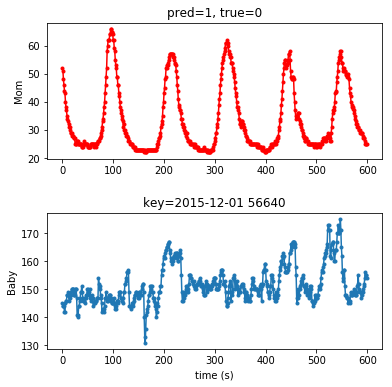

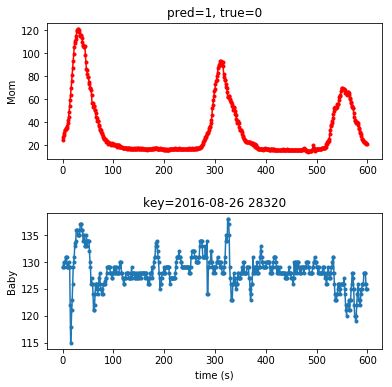

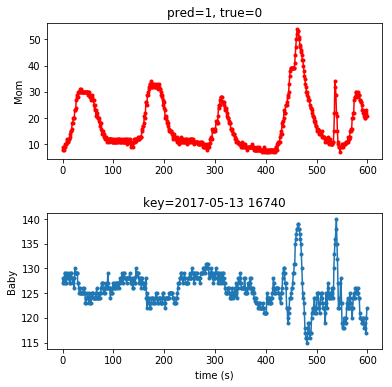

In [34]:
mom  = valid_dm[ypred != ytest]
baby = valid_db[ypred != ytest]

for i in range(mom.shape[0]):
    key = np.array(valid_d.key)[(ypred != ytest)][i]
    fig = plt.figure(figsize=(6,6))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    plt.subplot(2, 1, 1)
    plt.plot(mom[i,:], '.-', color='red')
    plt.ylabel('Mom')
    plt.title('pred={0}, true={1}'.format( ypred[(ypred != ytest)][i], ytest[(ypred != ytest)][i]))

    plt.subplot(2, 1, 2)
    plt.plot(baby[i,:], '.-')
    plt.xlabel('time (s)')
    plt.ylabel('Baby')
    plt.title('key={0}'.format(key))

    plt.savefig(os.path.join(FLAG_model_save, 'wrong/'+key+'.png'))
    plt.show()
    plt.close()

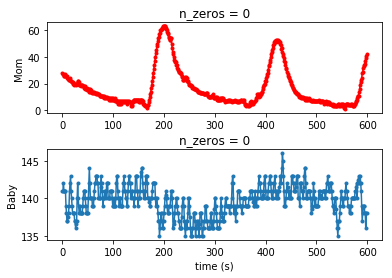

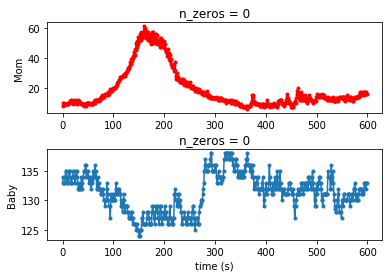

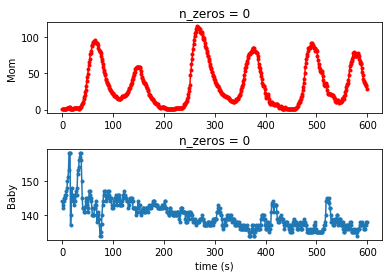

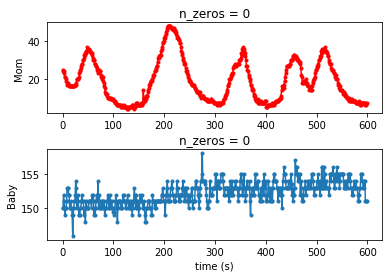

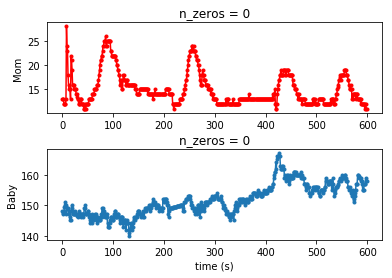

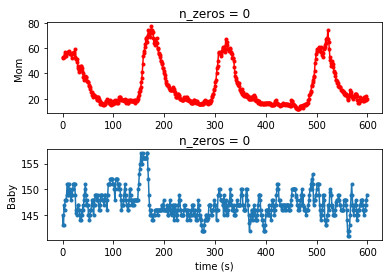

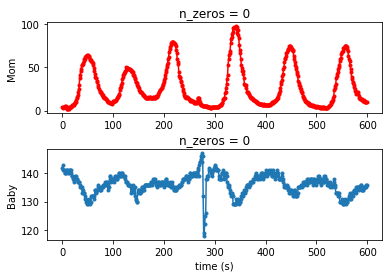

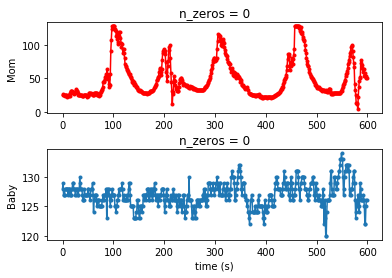

In [35]:
mom  = valid_dm[(ypred + ytest) == 2]
baby = valid_db[(ypred + ytest) == 2]

for i in range(mom.shape[0]):
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    plt.subplot(2, 1, 1)
    plt.plot(mom[i,:], '.-', color='red')
    plt.ylabel('Mom')
    plt.title('n_zeros = {0}'.format(get_n_zeros(mom[i:(i+1),:])[0]))

    plt.subplot(2, 1, 2)
    plt.plot(baby[i,:], '.-')
    plt.xlabel('time (s)')
    plt.ylabel('Baby')
    plt.title('n_zeros = {0}'.format(get_n_zeros(baby[i:(i+1),:])[0]))

    plt.show()
    plt.close()
    # plt.savefig(os.path.join(data_dir, '../eda/'+key[i]+'.png'))type=np.float)

In [38]:
from sklearn.metrics import confusion_matrix, classification_report

In [39]:
print(classification_report(y_pred=ypred, y_true=ytest))

             precision    recall  f1-score   support

          0       1.00      0.76      0.86        46
          1       0.42      1.00      0.59         8

avg / total       0.91      0.80      0.82        54



In [40]:
print(classification_report(y_pred=ypred_aug, y_true=ytest_aug))

             precision    recall  f1-score   support

          0       0.98      0.69      0.81       230
          1       0.34      0.93      0.50        40

avg / total       0.89      0.73      0.77       270



In [41]:
cfm = confusion_matrix(y_pred=ypred, y_true=ytest)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cfm, classes=np.arange(n_classes),
                      title='Confusion matrix, without normalization')
plt.savefig(os.path.join(FLAG_model_save, 'voting_confusion_matrix.png'))
plt.close()

Confusion matrix, without normalization
[[35 11]
 [ 0  8]]


In [42]:
cfm = confusion_matrix(y_pred=ypred_aug, y_true=ytest_aug)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cfm, classes=np.arange(n_classes),
                      title='Confusion matrix, without normalization')
plt.savefig(os.path.join(FLAG_model_save, 'segment_confusion_matrix.png'))
plt.close()

Confusion matrix, without normalization
[[159  71]
 [  3  37]]


#### t-SNE

In [43]:
feature_name = ''
for l in trained_model.layers:
    if 'global_average_pooling' in l.name:
        feature_name = l.name
if not feature_name:
    print('global_average_pooling layer not found')

In [102]:
features = trained_model.get_layer(feature_name)

In [103]:
extractor = Model(inputs=trained_model.input, outputs=features.output)

In [104]:
valid_feature_list = list()
valid_feature_list.append(extractor.predict(x=Xtest))

In [41]:
Fvalid = np.array(valid_feature_list[0])

In [48]:
from sklearn.manifold import TSNE

F_embedded = TSNE(n_components=2, perplexity=100).fit_transform(Fvalid)

In [49]:
labels = np.argmax(Ytest,axis=1)
color = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00']

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


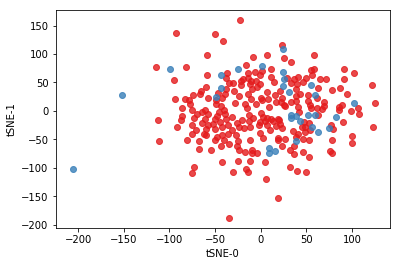

In [50]:
# F_embedded
for l in (set(labels)):
    plt.scatter(F_embedded[list(np.where(labels==l)[0]),0], F_embedded[list(np.where(labels==l)[0]),1],
                color=color[l], alpha=0.8)
plt.xlabel('tSNE-0')
plt.ylabel('tSNE-1')
legend=plt.legend(title='Altitude', fontsize=14)
